In [6]:
import pandas as pd
import json
import numpy as np
import time 
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from pymongo import MongoClient
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
# Set the ALS hyperparameters
from pyspark.ml.recommendation import ALS
# Import RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator


## Creating text-based similarity

### Import and Transform Data Products Metadata

In [63]:
start_time = time.time()

In [64]:
dataset1 = load_dataset("McAuley-Lab/Amazon-Reviews-2023","raw_meta_Cell_Phones_and_Accessories", split="full", trust_remote_code=True)
print(dataset[0])

{'main_category': 'Cell Phones & Accessories', 'title': 'ARAREE Slim Diary Cell Phone Case for Samsung Galaxy Note 5 - Retail Packaging - Coral Pink', 'average_rating': 3.8, 'rating_number': 5, 'features': ['Genuine Cow leather with 6 different colors', '3 Pockets for ID, Cards and receipts', 'The inside skin is made of microsuede, polycarbonate', "It doesn't have magnets The inner PC case color is gold", 'Made in Korea'], 'description': ["JUST LOOK, You can tell the difference. Make everyday more convenient, it is slim but has big rooms. If you are looking for a rich and luxurious appearance, look no further. These double shoulders are the perfect leather for creating attractive finished belts, straps and wallets. It doesn't only show the perfect weight for accessories where rugged durability is needed but also has a natural finish and coarse grain."], 'price': 'None', 'images': {'hi_res': [None, None, None, None, None, None, None], 'large': ['https://m.media-amazon.com/images/I/51Q9w

In [ ]:
products = []
# products_df = pd.DataFrame()

for product in dataset1:

    product_details = json.loads(product['details'])

    aux_product = {}
    aux_product['id'] = product['parent_asin']

    #Que tengan un titulo similar 
    aux_product['title'] = product['title']


    if 'Item Weight' in product_details.keys():
        #Que tengan un peso similar
        aux_product['weight'] = product_details['Item Weight'].split(' ')[0] or -1

    #Que tengan una categoria similar 
    aux_cat = ''
    #Add any categories that the product has, limited by 3
    for i,cat in enumerate(product['categories']):
        aux_cat += cat + ','
    aux_product[f"categorie"] = aux_cat
    
    aux_compatible = ''
    if 'Compatible Phone Models' in product_details.keys():
        for i,model in enumerate(product_details['Compatible Phone Models'].split(',')):
            # We only get the first 5 compatible phones
            aux_compatible += model + ','

    aux_product[f"compatible"] = aux_compatible

    aux_material = ''
    if 'Material' in product_details.keys():
        
        for i,material in enumerate(product_details['Material'].split(',')):
            aux_material += material + ','
        
    aux_product[f"material"] = aux_material

    aux_product['price'] = product['price'] or -1
    
    # Que tengan descripcion similar
    aux_product["description"] = product['description'] or np.nan

    aux_product["features"] = product['features'] or np.nan

    if len(product['images']['large']) > 0:
        aux_product["img"] = product['images']['large'][0] or np.nan
    else:
        aux_product["img"] = ''
        
    aux_product['avg_rating'] = product['average_rating'] or np.nan

    aux_product['url'] = 'https://amazon.com.mx/' + product['parent_asin']

    products.append(aux_product)


len(products)

1288490

In [ ]:
products_df = pd.DataFrame(products)
products_df.replace('', np.nan, inplace=True)
# Use this line to create the products dataframe and reduced the time to obtain the data to work with
# products_df.to_csv('./products_cleaned.csv',index=False)

In [ ]:
end_time = time.time()

In [ ]:
total_time_transform_data = end_time - start_time

### With Pandas and Sklearn

In [3]:
start_time = time.time()

Let's make a content-based recommender by the compability of products

1.  First we're gonna create a dataframe based on our cleaned and tranform products

In [5]:
products_df = pd.read_csv('./products_cleaned.csv')
products_df.head(5)

,id,title,weight,categorie,compatible,material,price,description,features,img,avg_rating,url
0,B013SK1JTY,ARAREE Slim Diary Cell Phone Case for Samsung ...,2.68,"Cell Phones & Accessories,Cases, Holsters & Sl...","Samsung Galaxy Note, Samsung Galaxy Note 5,","Leather, Polycarbonate,",NaN,"[""JUST LOOK, You can tell the difference. Make...",['Genuine Cow leather with 6 different colors'...,https://m.media-amazon.com/images/I/51Q9w96zIQ...,3.8,https://amazon.com.mx/B013SK1JTY
1,B07ZPSG8P5,Bastmei for OnePlus 7T Case Extremely Light Ul...,1.44,"Cell Phones & Accessories,Cases, Holsters & Sl...","OnePlus 7T,","Polycarbonate,",11.98,NaN,['Ultra-thin & Ultra-light: The ultra slim fit...,https://m.media-amazon.com/images/I/41Mo5IIOw6...,4.4,https://amazon.com.mx/B07ZPSG8P5
2,B00GKR3L12,Wireless Fones Branded New Iphone 5C/LITE Hot ...,NaN,"Cell Phones & Accessories,iPhone Accessories,",NaN,NaN,NaN,NaN,NaN,https://m.media-amazon.com/images/I/51qqm0cG4V...,4.0,https://amazon.com.mx/B00GKR3L12
3,B00PB8U8BW,"iPhone 6 Plus + Case, DandyCase Perfect PATTER...",0.80,"Cell Phones & Accessories,iPhone Accessories,","iPhone 6 Plus,","TPU,",NaN,['Case does not need to be removed for chargin...,"['Slim-Fit design for the iPhone 6 Plus (5.5"" ...",https://m.media-amazon.com/images/I/51DIzvm4V3...,4.0,https://amazon.com.mx/B00PB8U8BW
4,B07D3RHSRV,"Case for Galaxy S6/S6 Edge, Thin Translucent V...",2.92,"Cell Phones & Accessories,Cases, Holsters & Sl...","Samsung Galaxy S6,","Faux Leather, Polycarbonate,",NaN,NaN,NaN,https://m.media-amazon.com/images/I/11B94nE+l4...,4.0,https://amazon.com.mx/B07D3RHSRV


Once we got our products in a DataFrame, we will remove the rows which don't have data in the column `compatible`

In [101]:
products_clean_compatible_df = products_df.copy()
products_clean_material_df = products_df.copy()

products_clean_compatible_df.dropna(subset=['compatible'], inplace=True)
products_clean_material_df.dropna(subset=['material'], inplace=True)
products_clean_compatible_df.head()

,id,title,weight,categorie,compatible,material,price,description,features,img,avg_rating,url
0,B013SK1JTY,ARAREE Slim Diary Cell Phone Case for Samsung ...,2.68,"Cell Phones & Accessories,Cases, Holsters & Sl...","Samsung Galaxy Note, Samsung Galaxy Note 5,","Leather, Polycarbonate,",NaN,"[""JUST LOOK, You can tell the difference. Make...",['Genuine Cow leather with 6 different colors'...,https://m.media-amazon.com/images/I/51Q9w96zIQ...,3.8,https://amazon.com.mx/B013SK1JTY
1,B07ZPSG8P5,Bastmei for OnePlus 7T Case Extremely Light Ul...,1.44,"Cell Phones & Accessories,Cases, Holsters & Sl...","OnePlus 7T,","Polycarbonate,",11.98,NaN,['Ultra-thin & Ultra-light: The ultra slim fit...,https://m.media-amazon.com/images/I/41Mo5IIOw6...,4.4,https://amazon.com.mx/B07ZPSG8P5
3,B00PB8U8BW,"iPhone 6 Plus + Case, DandyCase Perfect PATTER...",0.80,"Cell Phones & Accessories,iPhone Accessories,","iPhone 6 Plus,","TPU,",NaN,['Case does not need to be removed for chargin...,"['Slim-Fit design for the iPhone 6 Plus (5.5"" ...",https://m.media-amazon.com/images/I/51DIzvm4V3...,4.0,https://amazon.com.mx/B00PB8U8BW
4,B07D3RHSRV,"Case for Galaxy S6/S6 Edge, Thin Translucent V...",2.92,"Cell Phones & Accessories,Cases, Holsters & Sl...","Samsung Galaxy S6,","Faux Leather, Polycarbonate,",NaN,NaN,NaN,https://m.media-amazon.com/images/I/11B94nE+l4...,4.0,https://amazon.com.mx/B07D3RHSRV
6,B0BHY2CR5B,"iMangoo Galaxy S22 Case, for Samsung Galaxy S2...",1.44,"Cell Phones & Accessories,Cases, Holsters & Sl...","Samsung Galaxy S22,","Faux Leather,",11.99,NaN,['Compatibility: This Galaxy S22 case is only ...,https://m.media-amazon.com/images/I/51nZu7lnhH...,4.5,https://amazon.com.mx/B0BHY2CR5B


Now we're gonna calculate the similarity of `compatible` column, for that we're going to create a TF-IDF("Term Frequency Inverse Document Frequency") vectorizer `TfidfVectorizer()` 

TF-IDF divides the number of times a word occurs in a document by a measure of what proportion of all the documents a word occurs in. 

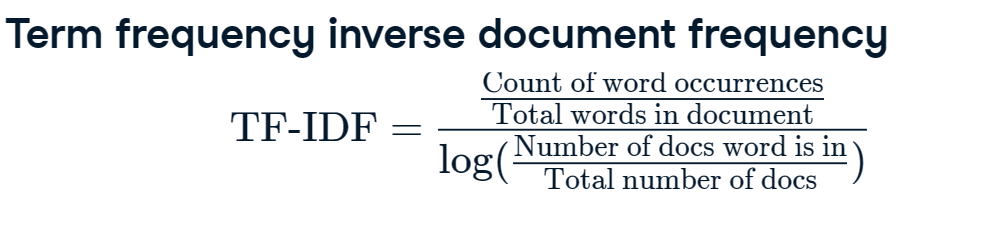

First, we set the min_df argument to two. This limits our features to only those that have occurred in at least two documents. Useful as terms occurring once are not valuable for finding similarities.

We should also remove words that are too common using max_df. By setting this to point seven, words that occur in more than 70% of the descriptions will be excluded.

`vectorized_descriptions` is a NxM dimension array, where N is the number of items and M the number of features

`tfid.get_feature_names_out()` shows the features that our vectorizer gets

In [102]:

tfid = TfidfVectorizer(min_df=10,max_df=0.7)
vectorized_descriptions = tfid.fit_transform(products_clean_compatible_df['compatible'])
features = tfid.get_feature_names_out()
data_vectorized = vectorized_descriptions.toarray()

#Make a dataframe with features and data

tfidf_df = pd.DataFrame(data_vectorized,columns=features,index=products_clean_compatible_df['id'])

tfidf_df.head()

,05e,10,1020,10e,10ft,10l,10pro,10r,10s,10t,...,zero,zfive,zmax,zone,zoom,zte,zuk,𝐌𝐚𝐱,𝐏𝐫𝐨,𝐢𝐏𝐡𝐨𝐧𝐞
id,,,,,,,,,,,,,,,,,,,,,
B013SK1JTY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B07ZPSG8P5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00PB8U8BW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B07D3RHSRV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0BHY2CR5B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use cosine similarity to find the similarity between two items or all items

In [6]:
cosine_similarity_array = cosine_similarity(tfidf_df)


cosine_similarity_df = pd.DataFrame(cosine_similarity_array,columns=products_clean_compatible_df['id'],index=products_clean_compatible_df['id'])
display(cosine_similarity_df.head())

Now we have our dataframe we can make queries about a product, for example: 

> Supose that we are searching for a samsung galaxy S6 case. Now our recommender engine will show the top 5 products that have the most similarity. our current product is `B07D3RHSRV`

In [ ]:
recomendations = cosine_similarity_df.loc['B07D3RHSRV'].sort_values(ascending=False)
top5_recomendations = recomendations.iloc[1:6]  # Exclude the first one (self-similarity)

#join our recomendations with our original data
recomendation_products = products_df[['title','description','img','avg_rating','url']][products_df['id'].isin(top5_recomendations.index)]

#Create the return array use, to json when we are exporting it
return_array = recomendation_products.to_dict(orient='records')


At this point, we can return different objects, suppose that we are working on a e-commerce, we will return data, that can be painted in a interface like this:

Our goal is return a json object 


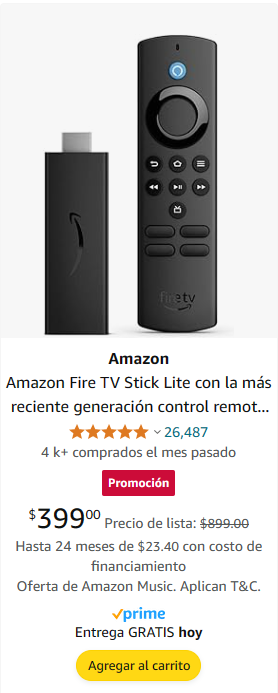

In [ ]:
end_time = time.time()

In [ ]:
total_time_content_based_pandas = end_time - start_time

## Creating user profiles

We will create user profiles based on what items did they bought based on verification reviews

### Import and Transform Data

In [36]:
start_time = time.time()

In [85]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023","raw_review_Cell_Phones_and_Accessories", split="full", trust_remote_code=True)
print(dataset[0])

{'rating': 4.0, 'title': 'No white background! It’s clear!', 'text': 'I bought this bc I thought it had the nice white background. Turns out it’s clear & since my phone is blue it doesn’t look anything like this.  If I had known that I would have purchased something else. It works ok.', 'images': [{'attachment_type': 'IMAGE', 'large_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL1600_.jpg', 'medium_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL800_.jpg', 'small_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL256_.jpg'}], 'asin': 'B08L6L3X1S', 'parent_asin': 'B08L6L3X1S', 'user_id': 'AFKZENTNBQ7A7V7UXW5JJI6UGRYQ', 'timestamp': 1612044451196, 'helpful_vote': 0, 'verified_purchase': True}


Algunos features que podemos utilizar para la categoria de Cell phones and Accesories:

details > Product Dimensions  > lenght , width ,height 
details > Item Weight  
details > Color
categories > 
Compatible Phone Models > "Check if there are standar models"
Material > separeate by comma
Screen Size > 5.7
price

The weight is on onces, the dimensions are in inches

We will use id product to differentiate between them

This dataset is around 9 GB we only store a maximum of 500 thousand iterations of all products from 2022 to 2023 including 2023

In [86]:
reviews = []
# products_df = pd.DataFrame()
i = 0
for review in dataset:

    if i > 500000:
        break

    # Calcular el timestamp para el 1 de enero de 2023 en milisegundos
    ts_2022 = pd.Timestamp('2022-01-01').timestamp() * 1000



    if review['verified_purchase'] is True and review['timestamp'] > ts_2022:
    
        aux_review = {}
        aux_review['rating'] = review['rating']

        #Que tengan un titulo similar 
        aux_review['title'] = review['title']

        #Analisis de sentimientos o reviews parecidas
        aux_review['text'] = review['text']

        #Producto asociado recomendar productos no comprados
        aux_review['id_product'] = review['parent_asin']

        #Producto asociado
        aux_review['id_user'] = review['user_id']

        #Compra verificada
        aux_review['verified_purchase'] = review['verified_purchase']

        aux_review['helpful_vote'] = review['helpful_vote']


        aux_review['url'] = 'https://amazon.com.mx/' + review['parent_asin']

        reviews.append(aux_review)

    i += 1

len(reviews)

63676

In [92]:
reviews_df = pd.DataFrame(reviews)
reviews_df.replace('', np.nan, inplace=True)


In [93]:
# Use this line to create the products dataframe and reduced the time to obtain the data to work with
reviews_df.to_csv('./reviews_cleaned.csv',index=False)

In [ ]:
end_time = time.time()

In [ ]:
total_time_transform_data_reviews  = end_time - start_time

### With Pandas and Sklearn

In [3]:
start_time = time.time()

In [94]:
reviews_df = pd.read_csv('./reviews_cleaned.csv')
reviews_df.head(5)

,rating,title,text,id_product,id_user,verified_purchase,helpful_vote,url
0,5.0,Works Great with my IPhone 13 & Magna Case!,This item works great with my IPhone 13 with M...,B0BX2GG16C,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,True,0,https://amazon.com.mx/B0BX2GG16C
1,5.0,Great item! Easy to install!,Item came as described! Fast shipping & east t...,B09DCT39P2,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,True,0,https://amazon.com.mx/B09DCT39P2
2,1.0,Returning as soon as I can.,I absolutely do not like this phone. Screen is...,B07WLLLTNZ,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,True,0,https://amazon.com.mx/B07WLLLTNZ
3,5.0,Very nice,Nice phone with decent sized screen. Charges f...,B08J4JYD47,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,True,2,https://amazon.com.mx/B08J4JYD47
4,5.0,excellent product,perfect for what I needed does take some movin...,B0BW8D4VC2,AHWWLSPCJMALVHDDVSUGICL6RUCA,True,0,https://amazon.com.mx/B0BW8D4VC2


We need to extract for each user which the products bought

In [95]:
# Extract products bought by each user
products_bought_by_user = reviews_df.groupby('id_user')['id_product'].unique().reset_index()

For example we want to recommend products for a user with more than 5 products bought

In [98]:
# Filter users who bought more than 5 products
products_from_user = products_bought_by_user[products_bought_by_user['id_product'].apply(len) > 5]
# Apply the funcion len() to know how many products bought each user 
products_from_user.loc[:,'id_product'] = products_from_user['id_product'].apply(len)
# Order users by who bought more products
products_from_user = products_from_user.sort_values(by='id_product', ascending=False)['id_product'].index[0]

# Obtain the products of the user who bought more products
products_from_user_to_recommend = products_bought_by_user['id_product'].loc[products_from_user]
products_from_user_to_recommend

array(['B0BVBBV2DQ', 'B0C9WSB3X7', 'B0C38SZ457', 'B09F5P6DTX',
       'B09WMSJB3Q', 'B0C2865XP9', 'B0BXJBK7VW', 'B0B5G41872',
       'B0C7BMX2PV', 'B0C2DDJ1GH', 'B0CB9WS8Z7', 'B0BK8ND57K',
       'B0CC812SCM', 'B0B5M73YKC', 'B0BZ3PBGQC', 'B0BK8VQTRS',
       'B0BWR5DW9T', 'B0BQQX54L6', 'B0B8ZC6T4G', 'B0BQQPZ6JR',
       'B0BWFBLZMG', 'B0C1XKX1ZC', 'B0BZSF7F9D', 'B0C7TPS1GF',
       'B0BWN88VSC', 'B0BQMBDPGF', 'B0BP7Q4FVZ', 'B0BPDDDXCY',
       'B0BJP61WVJ', 'B0BXW75JLD', 'B0B7LN5FD1', 'B0BNKR8YZ9',
       'B0C5X6CFF4', 'B0B95M2G3W', 'B0BL3RV7QM', 'B0BJDKTNHX',
       'B0B296Y4HH', 'B0BLVT44VD', 'B0BMVQRQZ9', 'B0BYYT8KFL',
       'B0B11M1K59', 'B0B5SN266F', 'B0B63MH2QC', 'B0BKGLGYPS',
       'B0BBDLLB6Z', 'B0BP6LFRB4', 'B0BD5B4LLG', 'B0BFDN24H2',
       'B0BGDG3JHL', 'B0BV5N8HF7', 'B0BZR3S6FB', 'B0BRXTMBLM',
       'B0BHNZ5GTH', 'B0BYCJTQH9', 'B0BHVXKK66', 'B0B28QQWK2',
       'B0BR9ZD6SH', 'B0BLSJLGX6', 'B09MVTF4C8', 'B0BHHJY4M9',
       'B0BGY8HK91', 'B0C1SJZX77', 'B0BD55F15N', 'B0BFF

Now we're going to create a user profile, which allows us to recommend products based on those that haven't been bought yet and have strong similarity.

So we have to load our TF-IDF dataframe from our content based recommender engine

In [103]:
products_bought = tfidf_df.reindex(products_from_user_to_recommend)

#Remove products that are not in the tfidf dataframe
products_bought.dropna(inplace=True)

# Generate the user profile by finding the average scores of products they bought
user_prof = products_bought.mean()

# Find subset of tfidf_df that does not products in products_from_user_to_recommend
tfidf_subset_df = tfidf_df.drop(tfidf_df.index.intersection(products_from_user_to_recommend))

# Calculate the cosine_similarity and wrap it in a DataFrame
similarity_array = cosine_similarity(user_prof.values.reshape(1, -1), tfidf_subset_df)
similarity_df = pd.DataFrame(similarity_array.T, index=tfidf_subset_df.index, columns=["similarity_score"])


# Sort the values from high to low by the values in the similarity_score
sorted_similarity_df = similarity_df.sort_values(by="similarity_score", ascending=False)

# Inspect the most similar to the user preferences
sorted_similarity_df.head()

,similarity_score
id,
B09BNC3VVT,0.915470
B0C3VQ1CN4,0.914767
B09QHH7N57,0.914765
B08V4ZG17J,0.906832
B0C2GN8Y3Y,0.904490


Now we can recommend 10 products to a user based on the products they've bought.

In [104]:
top5_recomendations = sorted_similarity_df.iloc[0:5] 

#join our recomendations with our original data
recomendation_products_user_profile = products_df[['title','description','img','avg_rating','url']][products_df['id'].isin(top5_recomendations.index)]

#Create the return array use, to json when we are exporting it
return_array_user_profile = recomendation_products_user_profile.to_dict(orient='records')

return_array_user_profile

[{'title': 'Easycosy Personalized Picture Phone Cases for 14 13 12 11 Pro/Max/Mini XR X Xs Max Custom Multiple Photo iPhone Case for Friends Family Birthday Gifts Customized Full Protection TPU Cover',
  'description': nan,
  'img': 'https://m.media-amazon.com/images/I/51xrFK8JBrL._AC_.jpg',
  'avg_rating': 4.4,
  'url': 'https://amazon.com.mx/B0C3VQ1CN4'},
 {'title': 'Quezqa Wireless Charging Station - 3 in 1 Fast Wireless Charger – Qi Fast Charging Dock for AirPods Pro 3 2 Apple Watch Ultra 8 7 SE 6 5 4 iPhone 14 Pro Max 14 Plus 13 12 11 Pro Max with QC Adapter',
  'description': nan,
  'img': 'https://m.media-amazon.com/images/I/41Od0hQStXL._AC_.jpg',
  'avg_rating': 4.0,
  'url': 'https://amazon.com.mx/B08V4ZG17J'},
 {'title': 'AFLYDOG Charging Station for Apple Multiple Devices, Adjustable 3 in 1 Charging Stand Dock Holder Foldable Charger Stand Compatible with Apple Watch SE/8/7/6/5/4/3/2/1 iPhone AirPods',
  'description': nan,
  'img': 'https://m.media-amazon.com/images/I/41SPk

## Collaborative filtering

### Creating Utility Matrix

We will find similarities using the user reviews 

Create a matrix with index users and products columns, the values will be the rating that each user gives to each item

In [19]:
start_time = time.time()
reviews_df = pd.read_csv('./reviews_cleaned.csv')
reviews_df.head(5)
 

,rating,title,text,id_product,id_user,verified_purchase,helpful_vote,url
0,5.0,Works Great with my IPhone 13 & Magna Case!,This item works great with my IPhone 13 with M...,B0BX2GG16C,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,True,0,https://amazon.com.mx/B0BX2GG16C
1,5.0,Great item! Easy to install!,Item came as described! Fast shipping & east t...,B09DCT39P2,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,True,0,https://amazon.com.mx/B09DCT39P2
2,1.0,Returning as soon as I can.,I absolutely do not like this phone. Screen is...,B07WLLLTNZ,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,True,0,https://amazon.com.mx/B07WLLLTNZ
3,5.0,Very nice,Nice phone with decent sized screen. Charges f...,B08J4JYD47,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,True,2,https://amazon.com.mx/B08J4JYD47
4,5.0,excellent product,perfect for what I needed does take some movin...,B0BW8D4VC2,AHWWLSPCJMALVHDDVSUGICL6RUCA,True,0,https://amazon.com.mx/B0BW8D4VC2


To make the process more visible, we will take a user and a product that appear more than 5 times

* Product : `B09DCT39P2`
* User : `AH4NV5I7WLS5GYM5NTQVV6KHSVNQ`

39907 users

29718 products


after filtered data :

21320 users

13867 products

unique users  = 4908

In [20]:
# display(reviews_df.groupby(['id_user']).agg({'rating':'count'}).sort_values(by='rating',ascending=False).loc['AH4NV5I7WLS5GYM5NTQVV6KHSVNQ'])

# display(reviews_df[(reviews_df['id_product'] == 'B09DCT39P2') & (reviews_df['id_user'] == 'AEBDKPMDIM267M2A2JNR37RTNIRQ')])

# display(reviews_df[reviews_df['id_product'] == 'B09DCT39P2'])
# reviews_df.loc['B0C6THW2BD']

# len(reviews_df.groupby(['id_product']).count().index)



At this point the dataset doesn't have the shape that we need, so we need to have a row of user and the columns will be the ratings of all products

In [21]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix

reviews_df_cp = reviews_df.copy()

#We only have users that bought more than 10 products
filtered_reviews = reviews_df_cp.groupby(['id_user']).count() 
filtered_reviews = filtered_reviews.sort_values(['rating'],ascending=False)

filtered_users = filtered_reviews[filtered_reviews['rating'] > 2].index.values

reviews_df_cp = reviews_df_cp.set_index('id_user')

filtered_df_reviews = reviews_df_cp.loc[filtered_users]

filtered_df_reviews.reset_index(inplace=True)

filtered_df_reviews = filtered_df_reviews.groupby(['id_user', 'id_product']).agg({'rating':'first'}).reset_index()


### Item-Item



we will fill the None values with 0, but this cause a huge error, so to avoid that we will centered the rating around 0


We need to transpose the matrix with the centered values around 0 and filled with 0

We tranpose the matrix to get the similarity between products and not between users


In [10]:
#Now we have our pivot table with the index as the users and the columns as the products, the values are the ratings
filtered_df_reviews_pivot = filtered_df_reviews.pivot(values='rating',index='id_user',columns='id_product')

#Centered values around 0
avg_ratings = filtered_df_reviews_pivot.mean(axis=1)
user_ratings_pivot = filtered_df_reviews_pivot.sub(avg_ratings, axis=0)

#Fill missing values
user_ratings_pivot.fillna(0,inplace=True)


#Transpose to items rating per user
items_ratings_pivot = user_ratings_pivot.T

#Calculate cosine similarity to all products
similarities = cosine_similarity(items_ratings_pivot)

cosine_similarity_df = pd.DataFrame(similarities,index=items_ratings_pivot.index,columns=items_ratings_pivot.index)
cosine_similarity_df.head()

id_product,B001324FY6,B0014WRV32,B001AY18U6,B002BBJMO6,B002Q4AJ3G,B0036DDT74,B003D29LXY,B003WUJV1O,B0046RE9CS,B004MM5YIU,...,B0CGRQS38P,B0CGTRXHMB,B0CGTSZ67Y,B0CGX8RVGF,B0CH2HMRY3,B0CHG154ZJ,B0CHK6LG7P,B0CHSHT1BW,B0CHVXLDJ9,B0CKF942NY
id_product,,,,,,,,,,,,,,,,,,,,,
B001324FY6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0014WRV32,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B001AY18U6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B002BBJMO6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B002Q4AJ3G,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


When we don't filter we have the error:

`MemoryError: Unable to allocate 1.83 GiB for an array with shape (12104, 20247) and data type float64`

Now we can query similar products based on their ratings, for example we want to check with similar rated products with `B09DCT39P2` 

The most similar rated products are 

*   B07XCYVBSC    1.0
*   B09FXQW9P2    1.0
*   B093D8BPJ9    1.0
*   B0CFFDJC5L    1.0

In [11]:
cosine_similarity_series = cosine_similarity_df.loc['B09DCT39P2']
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
display(ordered_similarities[0:5])

id_product
B09DCT39P2    1.000000
B0BVM4NNCX    0.161491
B09DHFF1BT    0.151397
B09G6PCH14    0.121118
B09F3HL7TP    0.100776
Name: B09DCT39P2, dtype: float64

#### TO DO

Show the average rating of these products, including the query product

### User-User

#### Using K-NN to make recommendations

To create a K-NN recommendations we need 2 datasets:

1. User-Product pivot table centered around 0 (Utility Matrix)
2. Orignal Utility matrix without missing values  (user_ratings_table)

Now to use K-NN algorithm we need to create another dataset: 

User-User pivot table, to known the similarity between users

##### User-User similiarity Matrix

In [12]:
#Now we have our pivot table with the index as the users and the columns as the products, the values are the ratings
filtered_df_reviews_pivot = filtered_df_reviews.pivot(values='rating',index='id_user',columns='id_product')

user_ratings_table = filtered_df_reviews_pivot

#Centered values around 0
avg_ratings = filtered_df_reviews_pivot.mean(axis=1)
user_ratings_pivot = filtered_df_reviews_pivot.sub(avg_ratings, axis=0)

#Fill missing values
user_ratings_pivot.fillna(0,inplace=True)


#Calculate cosine similarity to all products
similarities_user = cosine_similarity(user_ratings_pivot)

cosine_similarity_df_user = pd.DataFrame(similarities_user,index=user_ratings_pivot.index,columns=user_ratings_pivot.index)
cosine_similarity_df_user.head()

id_user,AE22CFXT3QZKUQJORVTGL3VQXAAA,AE22WBL7CHVN45VKVWSMMP7OSMOQ,AE24AP4G6YYZYCHGRN4DBSG3M3NQ,AE252KDEEX7GPFSWZFX4ZNVZCN3A,AE25KLQYMTCXRLTPDBO3ICPB7UJA,AE25WFQLG2WQDBRIEA333DYF47LA,AE26N5BRXPJ6PH2RXRAZFSMUJ2HQ,AE27BGKN7C3ZIO44CTZTIWAV353A,AE27WJH3GDXPTGZSJ4DKOQDF2OOQ,AE2BHVSLEWHZAMUVNRAAMCRRTN4A,...,AHZSRG4E5BHQZNRTFDQSDDML54EQ,AHZTC5TQBNAKU7DNRLWSFZTAUFVQ,AHZTJHB7BM7ATQG3FD2O53U2VEPQ,AHZUCL5K35GJK2GMNPULUWDR4E4Q,AHZUCTUKB6XIBOSF7VANSL65ON3Q,AHZUP3ISQAEUT4OXJJQETKZDQRBQ,AHZUY4VHJWSQW6W6NSR3INBSJUCA,AHZXFHVVHZN7IGWWOAUJANWSH6NA,AHZXOVWWHD55RCWRD4WSU2VDJLIQ,AHZZJQYNVZUJNPNQ737ITGEQUB4A
id_user,,,,,,,,,,,,,,,,,,,,,
AE22CFXT3QZKUQJORVTGL3VQXAAA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE22WBL7CHVN45VKVWSMMP7OSMOQ,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE24AP4G6YYZYCHGRN4DBSG3M3NQ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE252KDEEX7GPFSWZFX4ZNVZCN3A,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE25KLQYMTCXRLTPDBO3ICPB7UJA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we can now how similar are users, for example, what users are similar to `AH4NV5I7WLS5GYM5NTQVV6KHSVNQ`

Mainly there are 3 similar users based on his reviews

1. AE3V5DPSY77OC5JLW5KWPOR7JFZQ  -  0.866025
2. AGQMG4STAS7RGBIZZT4LTL4IDFQQ  -  0.821584
3. AHC2IDQXCMJMBYSIOOFSZTZIF4JA  -  0.821584

* Product : `B09DCT39P2`
* User : `AH4NV5I7WLS5GYM5NTQVV6KHSVNQ`

In [13]:
nearest_neighbors = cosine_similarity_df_user.loc['AH4NV5I7WLS5GYM5NTQVV6KHSVNQ'].sort_values(ascending=False)[1:3].index
display(nearest_neighbors)

Index(['AE3V5DPSY77OC5JLW5KWPOR7JFZQ', 'AGQMG4STAS7RGBIZZT4LTL4IDFQQ'], dtype='object', name='id_user')

Based on this neighbors, what is the rating of a given product, for example `B09DCT39P2`

Make the query for a product that the user didn't buy but their neighbors did.

In [14]:
# filtered_df_reviews_pivot.loc['AH4NV5I7WLS5GYM5NTQVV6KHSVNQ'].dropna()


In [15]:

neighbor_ratings = user_ratings_table.reindex(nearest_neighbors)

neighbor_ratings['B09DCT39P2'].mean()


1.5

##### K-NN Prediction

The process to make a prediction is as follows:

1. Drop the column of the product for which you want to predict the rating.
2. Select the user for whom you want to predict how much they like the chosen product (the rating needs to be null for that user) (x_test).
3. Extract all ratings from the original ratings dataset for the chosen product and drop missing values (y_train).
4. Extract from the User-User pivot table the users who rated the product (X_train).
5. Use KNN regressor to predict the rating that (x_test) will give to the chosen product, or use KNN Classifier to predict the most common rating for the chosen product.

##### Step 0 : Exploring the datasets

In [16]:
display(user_ratings_pivot.head(3))
display(user_ratings_table.head(3))

id_product,B001324FY6,B0014WRV32,B001AY18U6,B002BBJMO6,B002Q4AJ3G,B0036DDT74,B003D29LXY,B003WUJV1O,B0046RE9CS,B004MM5YIU,...,B0CGRQS38P,B0CGTRXHMB,B0CGTSZ67Y,B0CGX8RVGF,B0CH2HMRY3,B0CHG154ZJ,B0CHK6LG7P,B0CHSHT1BW,B0CHVXLDJ9,B0CKF942NY
id_user,,,,,,,,,,,,,,,,,,,,,
AE22CFXT3QZKUQJORVTGL3VQXAAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE22WBL7CHVN45VKVWSMMP7OSMOQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE24AP4G6YYZYCHGRN4DBSG3M3NQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


id_product,B001324FY6,B0014WRV32,B001AY18U6,B002BBJMO6,B002Q4AJ3G,B0036DDT74,B003D29LXY,B003WUJV1O,B0046RE9CS,B004MM5YIU,...,B0CGRQS38P,B0CGTRXHMB,B0CGTSZ67Y,B0CGX8RVGF,B0CH2HMRY3,B0CHG154ZJ,B0CHK6LG7P,B0CHSHT1BW,B0CHVXLDJ9,B0CKF942NY
id_user,,,,,,,,,,,,,,,,,,,,,
AE22CFXT3QZKUQJORVTGL3VQXAAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AE22WBL7CHVN45VKVWSMMP7OSMOQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AE24AP4G6YYZYCHGRN4DBSG3M3NQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
user_ratings_pivot1 = user_ratings_pivot.copy()
user_ratings_table1 = user_ratings_table.copy()

##### Steps 

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Step 1 : Dropping the column
user_ratings_pivot1.drop("B09DCT39P2", axis=1, inplace=True)

# Step 2: Select the user
target_user_x = user_ratings_pivot1.loc[["AH4NV5I7WLS5GYM5NTQVV6KHSVNQ"]]
# display(target_user_x)

# Step 3: Droping the column
other_users_y = user_ratings_table1["B09DCT39P2"]
# display(other_users_y)

# Step 4: Extract the users who rated the product
other_users_x = user_ratings_pivot1[other_users_y.notnull()]
# display(other_users_x)

# Step 3.5 : Drop None Values
other_users_y.dropna(inplace=True)
# display(other_users_y)


# Step 4: Use K-NN regressor
user_knn = KNeighborsClassifier(metric='cosine', n_neighbors=2)
user_knn.fit(other_users_x, other_users_y)
user_user_pred = user_knn.predict(target_user_x)
display(user_user_pred)


array([1.])

The predicted value is 1, and as we can see, the mean value of the nearest neighbors is 1.5.

##### TO DO

What happen with users with less rated products

use this collaborative filtering with item-item 

### Making predicctions with matrix Factorization

$$
\text{Sparsity} = \frac{\text{Empty Values}}{\text{Total cells}}
$$

So the 99% of the values are empty. This suggests that it would be limited in its value for making predictions using KNN. 

In [22]:
number_of_empty = user_ratings_table.isnull().values.sum()
total_number = user_ratings_table.size
sparsity = number_of_empty / total_number
print(sparsity)

0.9996867434715253


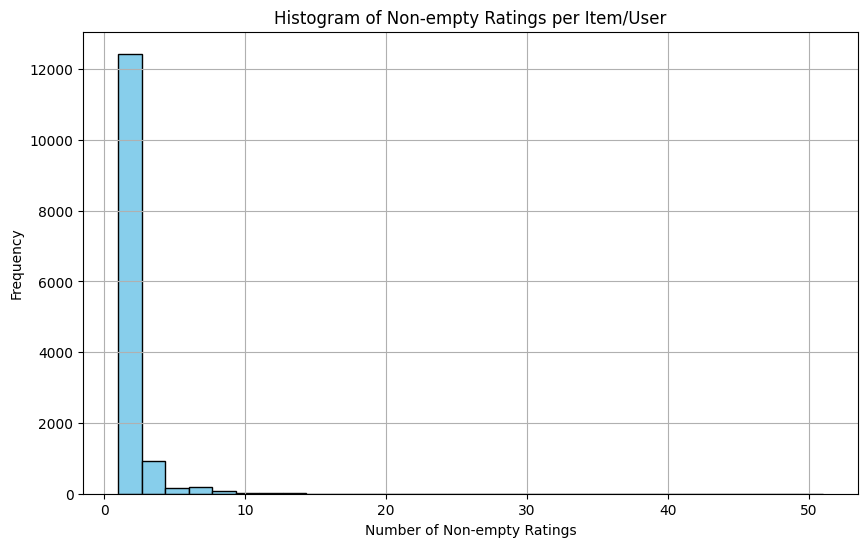

In [23]:
# Count the occupied cells per column
occupied_count = user_ratings_table.notnull().sum()


# Sort the resulting series from low to high
sorted_occupied_count = occupied_count.sort_values()



# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sorted_occupied_count, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Non-empty Ratings per Item/User')
plt.xlabel('Number of Non-empty Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

As we can see in the histogram, the highest frecuency of non-empty ratings is 1. This indicates that most of the products only have 1 review.


We need to do matrix factorization with SVD factorization we create a matrix with filled values 

In [24]:
#Now we have our pivot table with the index as the users and the columns as the products, the values are the ratings
user_ratings_df = filtered_df_reviews.pivot(values='rating',index='id_user',columns='id_product')


#Centered values around 0
avg_ratings = user_ratings_df.mean(axis=1)
user_ratings_pivot_centered = user_ratings_df.sub(avg_ratings, axis=0)

#Fill missing values
user_ratings_pivot_centered.fillna(0,inplace=True)

#Ratings centered around 0
display(user_ratings_pivot_centered.mean(axis=1).head(5))


id_user
AE22CFXT3QZKUQJORVTGL3VQXAAA   -1.601245e-20
AE22WBL7CHVN45VKVWSMMP7OSMOQ    0.000000e+00
AE24AP4G6YYZYCHGRN4DBSG3M3NQ    0.000000e+00
AE252KDEEX7GPFSWZFX4ZNVZCN3A    0.000000e+00
AE25KLQYMTCXRLTPDBO3ICPB7UJA    1.601245e-20
dtype: float64

In [25]:
from scipy.sparse.linalg import svds
import scipy.sparse as sp

# Convert DataFrame to a sparse matrix
user_ratings_sparse = sp.csr_matrix(user_ratings_pivot_centered.values)

# Perform SVD
U, sigma, Vt = svds(user_ratings_sparse)

#Conver sigma into diagonal matrix
sigma = np.diag(sigma)


# Dot product of U and sigma
U_sigma = np.dot(U, sigma)

# Dot product of result and Vt
U_sigma_Vt = np.dot(U_sigma, Vt)

# Add the row means back contained in avg_ratings
uncentered_ratings = U_sigma_Vt + avg_ratings.values.reshape(-1, 1)


# Create DataFrame of the results
calc_pred_ratings_df = pd.DataFrame(uncentered_ratings, 
                                    index=user_ratings_df.index,
                                    columns=user_ratings_df.columns
                                   )
# Print both the recalculated matrix and the original 
display(calc_pred_ratings_df)
display(user_ratings_df)


id_product,B001324FY6,B0014WRV32,B001AY18U6,B002BBJMO6,B002Q4AJ3G,B0036DDT74,B003D29LXY,B003WUJV1O,B0046RE9CS,B004MM5YIU,...,B0CGRQS38P,B0CGTRXHMB,B0CGTSZ67Y,B0CGX8RVGF,B0CH2HMRY3,B0CHG154ZJ,B0CHK6LG7P,B0CHSHT1BW,B0CHVXLDJ9,B0CKF942NY
id_user,,,,,,,,,,,,,,,,,,,,,
AE22CFXT3QZKUQJORVTGL3VQXAAA,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,...,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667,1.666667
AE22WBL7CHVN45VKVWSMMP7OSMOQ,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,...,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000,4.500000
AE24AP4G6YYZYCHGRN4DBSG3M3NQ,4.625000,4.625000,4.625000,4.625000,4.625000,4.625000,4.625001,4.625000,4.625000,4.625000,...,4.625048,4.625000,4.624959,4.625000,4.625000,4.624980,4.625000,4.625000,4.625000,4.625000
AE252KDEEX7GPFSWZFX4ZNVZCN3A,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,...,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000,4.750000
AE25KLQYMTCXRLTPDBO3ICPB7UJA,1.333333,1.333333,1.333333,1.333333,1.333333,1.333333,1.333333,1.333333,1.333333,1.333333,...,1.333333,1.333333,1.333333,1.333333,1.333333,1.333333,1.333333,1.333333,1.333333,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AHZUP3ISQAEUT4OXJJQETKZDQRBQ,4.400000,4.400000,4.400000,4.400000,4.400000,4.400000,4.400000,4.400000,4.400000,4.400000,...,4.400000,4.400000,4.400000,4.400000,4.400000,4.400000,4.400000,4.400000,4.400000,4.400000
AHZUY4VHJWSQW6W6NSR3INBSJUCA,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.999995,4.000000,4.000000,4.000000,...,3.999983,4.000000,3.999942,4.000000,4.000000,3.999971,4.000000,4.000000,4.000000,4.000000
AHZXFHVVHZN7IGWWOAUJANWSH6NA,3.166667,3.166667,3.166667,3.166667,3.166667,3.166667,3.166667,3.166667,3.166667,3.166667,...,3.166666,3.166667,3.166666,3.166667,3.166667,3.166666,3.166667,3.166667,3.166667,3.166667


id_product,B001324FY6,B0014WRV32,B001AY18U6,B002BBJMO6,B002Q4AJ3G,B0036DDT74,B003D29LXY,B003WUJV1O,B0046RE9CS,B004MM5YIU,...,B0CGRQS38P,B0CGTRXHMB,B0CGTSZ67Y,B0CGX8RVGF,B0CH2HMRY3,B0CHG154ZJ,B0CHK6LG7P,B0CHSHT1BW,B0CHVXLDJ9,B0CKF942NY
id_user,,,,,,,,,,,,,,,,,,,,,
AE22CFXT3QZKUQJORVTGL3VQXAAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AE22WBL7CHVN45VKVWSMMP7OSMOQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AE24AP4G6YYZYCHGRN4DBSG3M3NQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AE252KDEEX7GPFSWZFX4ZNVZCN3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AE25KLQYMTCXRLTPDBO3ICPB7UJA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AHZUP3ISQAEUT4OXJJQETKZDQRBQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AHZUY4VHJWSQW6W6NSR3INBSJUCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AHZXFHVVHZN7IGWWOAUJANWSH6NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
